Comparando clasificadores. <br>

También implementado PCA y cross-validation.

En digits['images'] se encuentran las imágenes en matrices 8x8.
En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.
En digits['data'] se encuentra la información a entrenar. Tamaño: (1797, 64)
Ejemplo [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 



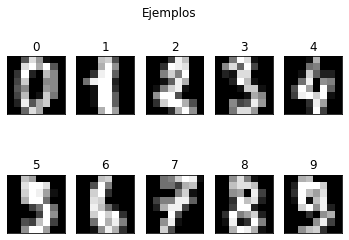

In [8]:
#Cargar dataset
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

digits = datasets.load_digits()

print("En digits['images'] se encuentran las imágenes en matrices 8x8.")
print("En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.")
print(f"En digits['data'] se encuentra la información a entrenar. Tamaño: {digits['data'].shape}")
print("Ejemplo",digits["data"][0],"\n")

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(digits["images"][num],cmap='gray')
    ax.set_title(digits["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)



Balance de clases dentro del total de muestras


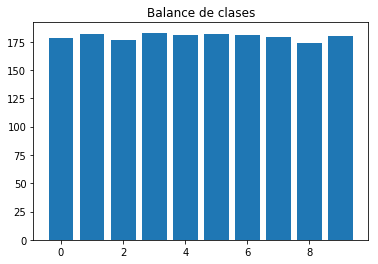

In [9]:
#Clases
plt.figure()
class_counts=np.unique(digits["target"], return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases")
print("Balance de clases dentro del total de muestras")

Set de entrenamiento con el 75% de muestras: (1347, 64)
Balance de clases dentro del set de entrenamiento


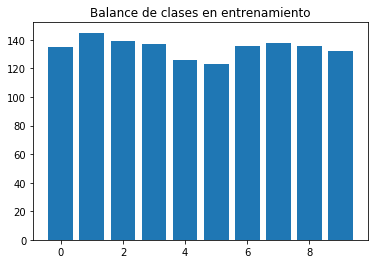

In [10]:
#Organizar train-test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(digits["data"],digits["target"],random_state=42,test_size=0.25)
print(f"Set de entrenamiento con el 75% de muestras: {X_train.shape}")

plt.figure()
class_counts=np.unique(y_train, return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases en entrenamiento")
print("Balance de clases dentro del set de entrenamiento")

Los primeros 21 componentes explican el 90.3% de la varianza de los dígitos.


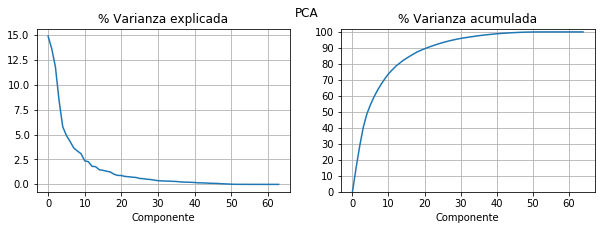

In [11]:
#PCA (tal vez buena idea hacer gridsearch para hallar número óptimo de parámetros)
from sklearn import decomposition
pca=decomposition.PCA()
X_pca=pca.fit_transform(digits["data"])

f,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(100*pca.explained_variance_ratio_)
f.suptitle("PCA")
ax[0].set_title("% Varianza explicada")
ax[0].set_xlabel("Componente")
ax[0].grid()

varianza_acumulada=np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(100*np.concatenate([[0],varianza_acumulada]))
ax[1].set_title("% Varianza acumulada")
ax[1].set_xlabel("Componente")
ax[1].set_yticks(range(0,101,10))
ax[1].set_ylim(0,102)
ax[1].grid()

#Se busca el índice del PC desde desde el cual se ha explicado el 90% de la varianza
PCA_idx=np.argwhere(varianza_acumulada>0.9)[0][0]
X_pca=X_pca[:,:PCA_idx]

#separa en train-test
Xpca_train,Xpca_test,ypca_train,ypca_test=train_test_split(X_pca,digits["target"],random_state=42,test_size=0.25)

print(f"Los primeros {PCA_idx+1} componentes explican el {100*varianza_acumulada[PCA_idx]:.1f}% de la varianza de los dígitos.")

Separación de clases en los dos primeros componentes principales
Si únicamente se ven los dos primeros componentes, se confunden varios números


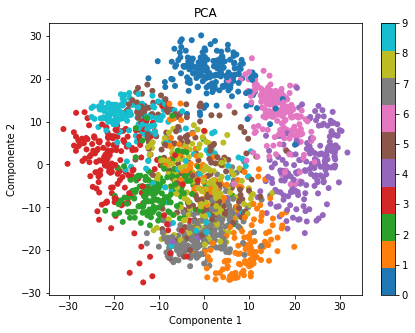

In [12]:
#Separación de componentes principales
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits["target"], edgecolor='none', alpha=1,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.title("PCA")
print("Separación de clases en los dos primeros componentes principales")
print("Si únicamente se ven los dos primeros componentes, se confunden varios números")

Mejores parámetros: {'logreg__C': 0.01, 'poly__degree': 2} con accuracy_score 97.70


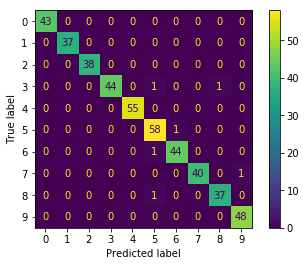

In [16]:
#Regresión logística sin PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])



param_grid = [{
    'poly__degree': [1,2],
    'logreg__C': [0.01,1,100],
}]

# pipe.set_params(poly__degree=1,logreg__C=1)
# pipe.fit(X_train,y_train)
# y_pred=pipe.predict(X_test)
# score=metrics.accuracy_score(y_test,y_pred)
# print(score)

search=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search.fit(X_train,y_train)
metrics.plot_confusion_matrix(search,X_test,y_test)
print(f"Mejores parámetros: {search.best_params_} con accuracy_score {100*search.best_score_:.2f}")

Mejores parámetros: {'logreg__C': 0.001, 'poly__degree': 3} con accuracy_score 97.85


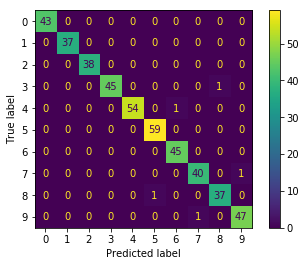

In [18]:
#Regresión logística con PCA
poly=PolynomialFeatures(include_bias=False)
logreg=LogisticRegression(random_state=42,max_iter=10000)
pipe=Pipeline(steps=[
        ("poly",poly),
        ("logreg",logreg)
])

param_grid = [{
    'poly__degree': [1,2,3],
    'logreg__C': [0.01,1,100],
}]

search=GridSearchCV(pipe,param_grid=param_grid,cv=3)
search.fit(Xpca_train,ypca_train)
metrics.plot_confusion_matrix(search,Xpca_test,ypca_test)
print(f"Mejores parámetros: {search.best_params_} con accuracy_score {100*search.best_score_:.2f}")
